In [475]:
import time
import json
import random
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain, repeat
import task_generation.taskset_generation as tg
import uuid
from enum import Enum
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# Task Generation

In [476]:
class PTask:
    def __init__(self, period, execution_time):
        self.period = period
        self.execution_time = execution_time

    @property
    def utilization(self):
        return self.execution_time / self.period

    def __str__(self):
        return f"({self.period}, {self.execution_time})"

    def __repr__(self):
        return f"({self.period}, {self.execution_time})"


class Task:
    def __init__(self, arrival_time, deadline, execution_time):
        self.id = uuid.uuid4()
        self.arrival_time = arrival_time
        self.deadline = deadline
        self.execution_time = execution_time
        self.start_time = 0
        self.finish_time = 0
        self.waiting_time = 0
        self.response_time = 0
        self.slack_time = 0

    @property
    def utilization(self):
        return self.execution_time / (self.deadline - self.arrival_time)

    def __str__(self):
        return f"({self.arrival_time}, {self.deadline}, {self.execution_time})"

    def __repr__(self):
        return f"({self.id}, {self.arrival_time}, {self.deadline}, {self.execution_time})"

In [477]:
def generate_ptasks(num_tasks=100, utilization=.5, available_periods=(1, 2, 4, 8, 16)):
    """
    Generates a set of periodic tasks with random periods and costs.
    """
    num_sets = 1
    u = np.array(tg.generate_uunifastdiscard(num_sets, utilization, num_tasks, 'test.csv'))
    p = np.array(tg.generate_random_periods_discrete(num_tasks, num_sets, available_periods))
    tset = np.array(tg.generate_tasksets(u, p, 'tset.csv'), dtype=[('cost', 'float64'), ('period', 'int32')])[0]
    tset = [PTask(tset['period'][i], tset['cost'][i]) for i in range(len(tset))]
    return tset


def generate_tasks(tset):
    """
    Generates a list of tasks from a set of periodic tasks.
    """
    if not tset:
        return []
    hp = np.lcm.reduce([t.period for t in tset])
    tasks = list(chain.from_iterable([
        zip(
            list(range(0, hp, tset[i].period)),
            list(range(tset[i].period, hp + 1, tset[i].period)),
            list(repeat(tset[i].execution_time, hp // tset[i].period))
        ) for i in range(len(tset))
    ]))
    # convert tasks to Task objects
    tasks = [Task(task[0], task[1], task[2]) for task in tasks]
    return tasks


# Task Mapping

In [478]:
class MAPPING_ALGORITHM(Enum):
    """
    An enum representing the mapping algorithm to use.
    """
    FIRST_FIT_DECREASING = 1
    BEST_FIT_DECREASING = 2
    WORST_FIT_DECREASING = 3
    FIRST_FIT_INCREASING = 4
    BEST_FIT_INCREASING = 5
    WORST_FIT_INCREASING = 6


def map_tasks_to_cores(ptasks, num_cores, mapping_algorithm):
    """
    Maps tasks to cores using the specified mapping algorithm.
    """
    # sort tasks based on utilization based on the mapping algorithm
    if mapping_algorithm.value <= 3:
        ptasks.sort(key=lambda task: task.utilization, reverse=True)
    else:
        ptasks.sort(key=lambda task: task.utilization, reverse=False)

    core_remaining_utilization = [1 / num_cores for _ in range(num_cores)]
    core_tasks = [[] for _ in range(num_cores)]

    # map tasks to cores
    for task in ptasks:
        if mapping_algorithm.value % 3 == 1:
            # first fit
            for i in range(num_cores):
                if core_remaining_utilization[i] >= task.utilization:
                    core_tasks[i].append(task)
                    core_remaining_utilization[i] -= task.utilization
                    break
            else:
                raise Exception('No core has enough remaining utilization to map task.')
        elif mapping_algorithm.value % 3 == 2:
            # best fit
            best_fit = -1
            for i in range(num_cores):
                if core_remaining_utilization[i] >= task.utilization:
                    if best_fit == -1 or core_remaining_utilization[i] < core_remaining_utilization[best_fit]:
                        best_fit = i
            if best_fit != -1:
                core_tasks[best_fit].append(task)
                core_remaining_utilization[best_fit] -= task.utilization
            else:
                raise Exception('No core has enough remaining utilization to map task.')
        else:
            # worst fit
            worst_fit = -1
            for i in range(num_cores):
                if core_remaining_utilization[i] >= task.utilization:
                    if worst_fit == -1 or core_remaining_utilization[i] > core_remaining_utilization[worst_fit]:
                        worst_fit = i
            if worst_fit != -1:
                core_tasks[worst_fit].append(task)
                core_remaining_utilization[worst_fit] -= task.utilization
            else:
                raise Exception('No core has enough remaining utilization to map task.')

    return core_tasks


# Utility Functions

In [479]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# def plot_results(num_tasks_list, ga_results, improved_ga_results):
#     fig, ax = plt.subplots()
#     x = range(len(num_tasks_list))
#     ax.bar(x, ga_results, width=0.3, label="GA")
#     ax.bar([i + 0.3 for i in x], improved_ga_results, width=0.3, label="Improved GA")
#     ax.set_xticks([i + 0.15 for i in x])
#     ax.set_xticklabels(num_tasks_list)
#     ax.set_xlabel("Number of Tasks")
#     ax.set_ylabel("Average Time")
#     ax.set_title("Average Times for Different Number of Tasks")
#     ax.legend()

#     plt.savefig("results.png")
#     plt.show()

def write_results_to_file(results, scheduler, mapping, utilization, num_cores, goals):
    scheduler_name = scheduler.__name__
    mapping_name = mapping.name
    goals_name = '_'.join([goal.name for goal in goals])
    with open("results/"+"__".join([scheduler_name, mapping_name, str(utilization), str(num_cores), goals_name]) + ".json", "w") as file:
        json.dump({"results": results}, file)

def read_results_from_file(scheduler, mapping, utilization, num_cores, goals):
    scheduler_name = scheduler.__name__
    mapping_name = mapping.name
    goals_name = '_'.join([goal.name for goal in goals])
    with open("results/"+"__".join([scheduler_name, mapping_name, str(utilization), str(num_cores), goals_name]) + ".json", "r") as file:
        data = json.load(file)
    return data["results"]

def read_tasks_from_file(file_path):
    with open("inputs/" + file_path, "r") as file:
        data = json.load(file)

    tasks = []
    for per_core_tasks_data in data["tasks"]:
        per_core_tasks = []
        for task_data in per_core_tasks_data:
            task = Task(task_data["arrival_time"], task_data["deadline"], task_data["execution_time"])
            per_core_tasks.append(task)
        tasks.append(per_core_tasks)

    return tasks


def write_tasks_to_file(tasks):
    file_name = uuid.uuid4().hex + ".json"
    with open("inputs/" + file_name, "w") as file:
        json.dump({"tasks": [[{
            "arrival_time": task.arrival_time,
            "deadline": task.deadline,
            "execution_time": task.execution_time
        } for task in taskset] for taskset in tasks]}, file)
    return file_name

class GOAL(Enum):
    """
    An enum representing the goal to optimize.
    """
    COMPLETION_TIME = 1
    LATENESS = 2
    WAIT_TIME = 3
    RESP_TIME = 4
    SLACK_TIME = 5

def calc_goal_val(goals, final_time, avg_lateness, avg_wait_time, avg_resp_time, avg_slack_time):
    val = 0
    if GOAL.COMPLETION_TIME in goals:
        val += final_time
    if GOAL.LATENESS in goals:
        val += avg_lateness
    if GOAL.WAIT_TIME in goals:
        val += avg_wait_time
    if GOAL.RESP_TIME in goals:
        val += avg_resp_time
    if GOAL.SLACK_TIME in goals:
        val += avg_slack_time
    return val

# PSO

In [480]:
class Particle:
    def __init__(self):
        self._order = None
        self.best = None
        self.fitness = None
        self.final_time = None
        self.avg_lateness = None
        self.avg_wait_time = None
        self.avg_resp_time = None
        self.avg_slack_time = None

    def set_order(self, order):
        self._order = order
        return self

    def get_order(self):
        return self._order

    def save_if_better(self, particle):
        if self.best is None or (self.best.fitness < particle.fitness and
                                 ((self.best.avg_lateness > 0) or (particle.avg_lateness == 0))):
            self.best = particle.copy()

    def copy(self):
        particle = Particle()
        particle.set_order(self._order.copy())
        particle.fitness = self.fitness
        particle.final_time = self.final_time
        particle.avg_lateness = self.avg_lateness
        particle.avg_wait_time = self.avg_wait_time
        particle.avg_resp_time = self.avg_resp_time
        particle.avg_slack_time = self.avg_slack_time
        return particle


class PSOScheduler:
    def __init__(self, w, c1, c2, tasks, goal):
        self.particles, self.particle_count = None, None
        self.best_keeper = Particle()
        self.tasks = tasks
        self.w, self.c1, self.c2 = w, c1, c2
        self.goal = goal

    def calculate_fitness(self, particle):
        final_time, avg_wait_time, avg_resp_time, avg_lateness, avg_slack_time = self.evaluate(particle.get_order())
        # fitness = -(100*self.sigmoid(avg_lateness)**(1/10) + self.sigmoid(avg_resp_time + avg_wait_time))
        fitness = 1 / (10*np.exp(avg_lateness*10) + calc_goal_val(
            self.goal, final_time, avg_lateness, avg_wait_time, avg_resp_time, avg_slack_time))
        # fitness = 1/(np.exp(avg_lateness*10 + avg_resp_time + avg_wait_time))

        particle.fitness, particle.avg_lateness, particle.avg_wait_time, particle.avg_resp_time, particle.avg_slack_time, particle.final_time = fitness, avg_lateness, avg_wait_time, avg_resp_time, avg_slack_time, final_time
        particle.save_if_better(particle)

    def evaluate(self, order):
        """
        Evaluates an order by simulating the execution of the tasks.

        Args:
            order (list): A list representing the order of tasks to be executed.
        Returns:
            tuple: A tuple containing the full time, final time, wait time, response time, and slack time.
        """
        final_time = 0
        wait_time = 0
        resp_time = 0
        lateness = 0
        slack_time = 0

        for task_id in order:
            task = self.tasks[task_id]
            task.start_time = max(task.arrival_time, final_time)
            task.finish_time = task.start_time + task.execution_time
            task.waiting_time = task.start_time - task.arrival_time
            task.response_time = task.finish_time - task.arrival_time
            task.lateness = task.finish_time - task.deadline
            task.slack_time = task.start_time - final_time

            final_time = task.finish_time
            wait_time += task.waiting_time
            resp_time += task.response_time
            lateness += max(0, task.lateness)
            slack_time += task.slack_time

        return final_time, wait_time/len(order), resp_time/len(order), lateness/len(order), slack_time/len(order)

    def initiate_swarm(self, particle_count):
        self.particle_count = particle_count
        self.particles = []
        for _ in range(self.particle_count):
            order = list(range(len(self.tasks)))
            random.shuffle(order)
            particle = Particle()
            particle.set_order(order)
            self.calculate_fitness(particle)
            self.best_keeper.save_if_better(particle.best)
            self.particles.append(particle)

    def move_particles(self):
        for particle in self.particles:
            self.local_search(particle)  # M1
            self.path_relinking(particle, self.best_keeper.best.get_order(), self.c2)  # M3
            self.path_relinking(particle, particle.best.get_order(), self.c1)  # M2

    def local_search(self, particle):
        """
        insert some of the tasks with the highest lateness in the first position after its release time
        """
        steps = int(len(self.tasks) / 10 * self.w)
        # steps = int(len(self.tasks) / 10 * random.uniform(.2, 1))
        if steps == 0:
            steps = 1

        x = particle.get_order()
        self.evaluate(x) # O(n)
        lateness = [(self.tasks[task_id].lateness, task_id) for task_id in x] # O(n)
        tasks_to_move = [task_id for _, task_id in sorted(lateness, reverse=True)[:steps]] # O(nlogn)
        arrival_times = [(self.tasks[task_id].arrival_time, task_id) for task_id in tasks_to_move]
        arrival_times.sort() # O(nlogn)
        arrival_index = 0
        task_id_to_order = {task_id: i for i, task_id in enumerate(x)}
        for task_id in x:
            if self.tasks[task_id].start_time >= arrival_times[arrival_index][0]:
                task_to_move = arrival_times[arrival_index][1]
                task_id_to_order[task_to_move] = task_id_to_order[task_id] - .5
                arrival_index += 1
                if arrival_index == len(arrival_times):
                    break
        x = [task_id for task_id, _ in sorted(task_id_to_order.items(), key=lambda xx: xx[1])]
        particle.set_order(x)
        self.calculate_fitness(particle) # O(n)
        self.best_keeper.save_if_better(particle.best)


    @staticmethod
    def calculate_distance(x, y):
        """
        Calculates the distance between two orders. i.e. the minimum number of swaps required to transform one order into the other.
        """
        x = x.copy()
        x_to_index = {task_id: i for i, task_id in enumerate(x)}
        swap_count = 0
        for i in range(len(x)):
            if x[i] != y[i]:
                swap_count += 1
                j = x_to_index[y[i]]
                x[i], x[j] = x[j], x[i]
                x_to_index[x[i]], x_to_index[x[j]] = x_to_index[x[j]], x_to_index[x[i]]
        return swap_count

    def path_relinking(self, particle, t, c):
        x = particle.get_order()
        max_distance = self.calculate_distance(x, t)
        phi = np.random.uniform(0, 1)
        steps = int((phi + c) / 2 * max_distance)
        x_to_index = {task_id: i for i, task_id in enumerate(x)}

        unequal_indices = [i for i in range(len(x)) if x[i] != t[i]]
        np.random.shuffle(unequal_indices)
        random_indices = unequal_indices[:steps]
        for step in range(steps):
            i = random_indices[step]
            j = x_to_index[t[i]]
            x[i], x[j] = x[j], x[i]
            x_to_index[x[i]], x_to_index[x[j]] = x_to_index[x[j]], x_to_index[x[i]]
        particle.set_order(x)
        self.calculate_fitness(particle)
        self.best_keeper.save_if_better(particle.best)

    def check_for_convergence(self):
        for i in range(1, len(self.particles)):
            particle0 = self.particles[i-1]
            particle1 = self.particles[i]
            if np.any(np.array(particle0.get_order()) != np.array(particle1.get_order())):
                return False
        return True

    def run(self, max_iterations):
        for i in tqdm(range(max_iterations)):
            # print(f"iteration {i}")
            self.move_particles()

            # print(f"ftime: {self.best_keeper.best.final_time:.4f}, avgwtime: {self.best_keeper.best.avg_wait_time:.4f}, avgrtime: {self.best_keeper.best.avg_resp_time:.4f}, avgstime: {self.best_keeper.best.avg_slack_time:.4f} avgl: {self.best_keeper.best.avg_lateness:.4f}")

            self.w -= (self.w - .01)/(max_iterations - i)*2
            # if self.check_for_convergence():
            #     break
        return self.best_keeper.best


In [481]:
def single_set_pso(tasks, goal):
    pso = PSOScheduler(.9, 0.8, 0.5, tasks, goal)
    pso.initiate_swarm(20)
    best = pso.run(1000)
    pso.evaluate(best.get_order())
    return {
        'order': best.get_order(),
        'fitness': best.fitness,
        'final_time': best.final_time,
        'avg_wait_time': best.avg_wait_time,
        'avg_resp_time': best.avg_resp_time,
        'avg_lateness': best.avg_lateness,
        'avg_slack_time': best.avg_slack_time,
        'slack_between': [task.slack_time for task in tasks],
        'lateness_per_task': [max(0, task.lateness) for task in tasks],
    }

In [482]:
def pso(tasks, goal):
    process_pool = ProcessPoolExecutor(max_workers=len(tasks))
    futures = [process_pool.submit(single_set_pso, tasks[i], goal) for i in range(len(tasks))]
    results = [future.result() for future in futures]
    return results

# GA

In [483]:
class Scheduler:
    def __init__(self, num_tasks, mutation_rate, crossover_rate, max_iter):
        self.num_tasks = num_tasks
        self.mutation_rate = mutation_rate
        self.population = []
        self.best_fitness = 0
        self.best_chromosome = []

    def initialize(self):
        # code to initialize population with random chromosomes
        pass

    def crossover(self):
        # code to perform crossover between parent chromosomes
        pass

    def mutate(self):
        # code to perform mutation on child chromosomes
        pass

    def fitness(self):
        # code to calculate fitness of each chromosome in the population
        pass

    def selection(self):
        # code to perform selection of fittest chromosomes for next generation
        pass

    def evolve(self, num_generations):
        # code to run GA algorithm for given number of generations
        pass

    def run(self, tasks):
        # code to run the scheduler for given tasks using GA algorithm
        pass

class GA_Scheduler(Scheduler):
    """
    A class representing the GA algorithm for task scheduling.
    """

    def __init__(self, num_tasks, mutation_rate, crossover_rate, max_iter, pop_size, goal):
        super().__init__(num_tasks, mutation_rate, crossover_rate, max_iter)
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.max_iter = max_iter
        self.goal = goal

    def initialize_population(self, num_tasks):
        """
        Initializes the population with random task orders.

        Args:
            num_tasks (int): Number of tasks.

        Returns:
            list: A list of task orders (chromosomes).
        """
        population = []
        for i in range(self.pop_size):
            chromosome = [j for j in range(num_tasks)]
            random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def calculate_fitness(self, population, tasks):
        """
        Calculates the fitness of each chromosome in the population.

        Args:
            population (list): A list of task orders (chromosomes).
            tasks (list): A list of Task objects.

        Returns:
            list: A list of tuples containing the chromosome and its fitness.
        """


        fitness_scores = []
        for chromosome in population:
            final_time, wait_time, resp_time, lateness, slack_time = self.evaluate(chromosome, tasks)
            # fitness = 1 / (1 + slack_time)
            # fitness = 100 * slack_time
            # fitness = 1 / (np.exp(lateness*10 + resp_time/10 + wait_time/10))
            fitness = 1 / (10*np.exp(lateness*10) + calc_goal_val(
                self.goal, final_time, wait_time, resp_time, lateness, slack_time))
            if lateness == 0:
                fitness *= 2
            fitness_scores.append((chromosome, fitness))
            # print(f"ftime: {final_time:.4f}, wtime: {wait_time:.4f}, rtime: {resp_time:.4f}, l: {lateness:.4f} fitness: {fitness:.4f} ", chromosome)
        return fitness_scores

    def evaluate(self, chromosome, tasks):
        """
        Evaluates a chromosome by simulating the execution of the tasks.

        Args:
            chromosome (list): A list representing the order of tasks to be executed.
            tasks (list): A list of Task objects.

        Returns:
            tuple: A tuple containing the full time, final time, wait time, response time, and slack time.
        """
        final_time = 0
        wait_time = 0
        resp_time = 0
        lateness = 0
        slack_time = 0


        task_copy = tasks.copy()
        # task_copy.sort(key=lambda x: x.arrival_time)

        s_time = []

        for task_id in chromosome:
            task = task_copy[task_id]
            task.start_time = max(task.arrival_time, final_time)
            task.finish_time = task.start_time + task.execution_time
            task.waiting_time = task.start_time - task.arrival_time
            task.response_time = task.finish_time - task.arrival_time
            task.lateness = task.finish_time - task.deadline
            task.slack_time = task.start_time - final_time

            final_time = task.finish_time
            wait_time += task.waiting_time
            resp_time += task.response_time
            lateness += max(0, task.lateness)
            slack_time += task.slack_time
            # s_time.append(task.lateness)

        return final_time, wait_time/len(tasks), resp_time/len(tasks), lateness/len(tasks), slack_time/len(tasks)

    def selection_old(self, fitness_scores):
        """
        Selects two parent chromosomes using tournament selection.

        Args:
            fitness_scores (list): A list of tuples containing the chromosome and its fitness.

        Returns:
            tuple: A tuple containing the two parent chromosomes.
        """
        # candidates = random.sample(fitness_scores, 2)

        candidates1 = max(fitness_scores, key=lambda x: x[1])
        fitness_scores_copy = fitness_scores.copy()
        fitness_scores_copy.remove(candidates1)
        candidates2 = max(fitness_scores_copy, key=lambda x: x[1])
        for _ in range(len(fitness_scores)):
            if candidates1 == candidates2:
                fitness_scores_copy.remove(candidates2)
            candidates2 = max(fitness_scores_copy, key=lambda x: x[1])
            if len(fitness_scores_copy) < 2:
                break
        # parent1 = max(candidates, key=lambda x: x[1])[0]

        # candidates = random.sample(fitness_scores, 2)
        # parent2 = max(candidates, key=lambda x: x[1])[0]

        return candidates1[0], candidates2[0]

    def selection(self, fitness_scores):
        """
        Selects two parent chromosomes using tournament selection.

        Args:
            fitness_scores (list): A list of tuples containing the chromosome and its fitness.

        Returns:
            tuple: A tuple containing the two parent chromosomes.
        """
        # generate two random integers with weights based on fitness
        weights = [x[1] for x in fitness_scores]
        # normalize weights
        sum_weights = sum(weights)
        weights = [x/sum_weights for x in weights]
        index1, index2 = random.choices(range(len(fitness_scores)), weights=weights, k=2)
        candidates1 = fitness_scores[index1]
        candidates2 = fitness_scores[index2]

        return candidates1[0], candidates2[0]

    def crossover(self, parent1, parent2):
        """
        Performs crossover between two parent chromosomes.

        Args:
            parent1 (list): The first parent chromosome.
            parent2 (list): The second parent chromosome.

        Returns:
            list: The child chromosome resulting from crossover.
        """
        crossover_point = random.randint(1, len(parent1) - 1)
        child = parent1[:crossover_point] + parent2[crossover_point:]

        return child

    def pbc_crossover(self, parent1, parent2):
        """
        Perform position-based crossover (PBC) on two parent chromosomes to create a new child chromosome.

        Parameters:
            parent1 (list): The first parent chromosome.
            parent2 (list): The second parent chromosome.

        Returns:
            list: The new child chromosome.
        """
        n = len(parent1)
        child = [-1] * n
        # Select random positions for the crossover points
        positions = sorted(random.sample(range(n), 2))
        # Copy the genetic material from the parents into the child chromosome
        for i in range(positions[0], positions[1]):
            child[i] = parent1[i]
        # Fill in the remaining positions in the child chromosome with genetic material from the second parent
        fast_child = set(child)
        j = 0
        for i in range(n):
            if not parent2[i] in fast_child:
                while child[j] != -1:
                    j += 1
                child[j] = parent2[i]
        return child

    def ox_crossover(self, parent1, parent2):
        """
        Perform order crossover (OX) on two parent chromosomes to create a new child chromosome.

        Parameters:
            parent1 (list): The first parent chromosome.
            parent2 (list): The second parent chromosome.

        Returns:
            list: The new child chromosome.
        """
        n = len(parent1)
        child = [-1] * n

        # Select two random positions for the crossover points
        positions = sorted(random.sample(range(n), 2))

        # Copy genetic material from the first parent into the child chromosome between the crossover points
        child[positions[0]:positions[1]] = parent1[positions[0]:positions[1]]

        # Fill in the remaining positions in the child chromosome with genetic material from the second parent
        j = positions[1]
        for i in range(n):
            if not parent2[i] in child:
                if j == n:
                    j = 0
                child[j] = parent2[i]
                j += 1

        return child

    def mutate(self, chromosome):
        """
        Mutates a chromosome.

        Args:
            chromosome (list): The chromosome to mutate.

        Returns:
            list: The mutated chromosome.
        """
        if random.random() < self.mutation_rate:
            idx1, idx2 = random.sample(range(len(chromosome)), 2)
            chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]

        return chromosome

    def smart_mutate(self, chromosome):
        x = chromosome
        steps = int(len(self.tasks)/10 * random.uniform(.2, 1))
        if steps == 0:
            steps = 1
        self.evaluate(x, self.tasks) # O(n)
        lateness = [(self.tasks[task_id].lateness, task_id) for task_id in x] # O(n)
        tasks_to_move = [task_id for _, task_id in sorted(lateness, reverse=True)[:steps]] # O(nlogn)
        arrival_times = [(self.tasks[task_id].arrival_time, task_id) for task_id in tasks_to_move]
        arrival_times.sort() # O(nlogn)
        arrival_index = 0
        task_id_to_order = {task_id: i for i, task_id in enumerate(x)}
        for task_id in x:
            if self.tasks[task_id].start_time >= arrival_times[arrival_index][0]:
                task_to_move = arrival_times[arrival_index][1]
                task_id_to_order[task_to_move] = task_id_to_order[task_id] - .5
                arrival_index += 1
                if arrival_index == len(arrival_times):
                    break
        x = [task_id for task_id, _ in sorted(task_id_to_order.items(), key=lambda x: x[1])]
        return x

    def evolve(self, population, fitness_scores):
        """
        Evolves the population by selecting parents, performing crossover and mutation, and generating a new population.

        Args:
            population (list): A list of task orders (chromosomes).
            fitness_scores (list): A list of tuples containing the chromosome and its fitness.

        Returns:
            list: A new list of task orders (chromosomes).
        """
        new_population = []

        for _ in range(len(population)):
            parent1, parent2 = self.selection(fitness_scores)
            # child = self.ox_crossover(parent1, parent2)
            child = self.pbc_crossover(parent1, parent2)
            # child = self.mutate(child)
            child = self.smart_mutate(child)
            new_population.append(child)

        return new_population

    def run(self, tasks):
        """
        Runs the GA

        """
        population = self.initialize_population(self.num_tasks)
        self.tasks = tasks

        best_ever_chromosome, best_ever_fitness, best_ever_lateness = None, None, None
        for i in tqdm(range(self.max_iter)):
            # print("Iteration: ", i)
            fitness_scores = self.calculate_fitness(population, tasks)
            population = self.evolve(population, fitness_scores)
            best_chromosome, best_fitness = max(fitness_scores, key=lambda x: x[1])
            final_time, avg_wait_time, avg_resp_time, avg_lateness, avg_slack_time = self.evaluate(best_chromosome, tasks)
            # print(f"ft: {final_time}, avgwt: {avg_wait_time}, avgrt: {avg_resp_time}, avgl: {avg_lateness}")

            if best_ever_fitness is None or (best_fitness > best_ever_fitness and ((best_ever_lateness > 0) or (avg_lateness == 0))):
                best_ever_chromosome = best_chromosome
                best_ever_fitness = best_fitness
                best_ever_lateness = avg_lateness

            self.mutation_rate -= (self.mutation_rate - 0.1) / (self.max_iter - i) * 1.5
        return best_ever_chromosome, best_ever_fitness, best_ever_lateness


In [484]:
def single_set_ga(tasks, goal):
    num_tasks = len(tasks)
    ga = GA_Scheduler(num_tasks, 0.8, 0.9, 1000, 100, goal)
    best_chromosome, best_fitness, best_lateness = ga.run(tasks)

    final_time, avg_wait_time, avg_resp_time, avg_lateness, avg_slack_time = ga.evaluate(best_chromosome, tasks)
    # print(f"fit: {best_fitness} ft: {final_time}, avgwt: {avg_wait_time}, avgrt: {avg_resp_time}, avgst: {avg_slack_time} avgl: {avg_lateness}")

    return {
        'order': best_chromosome,
        'fitness': best_fitness,
        'avg_lateness': avg_lateness,
        'avg_wait_time': avg_wait_time,
        'avg_resp_time': avg_resp_time,
        'avg_slack_time': avg_slack_time,
        'final_time': final_time,
        'slack_between': [task.slack_time for task in tasks],
        'lateness_per_task': [max(0, task.lateness) for task in tasks],
    }

In [485]:
def ga(tasks, goal):
    process_pool = ProcessPoolExecutor(max_workers=len(tasks))
    futures = [process_pool.submit(single_set_ga, tasks[i], goal) for i in range(len(tasks))]
    results = [future.result() for future in futures]
    return results

# Testing

In [492]:
def one_trial(scheduler, mapping, utilization, num_cores, goal):
    while True:
        ptasks = generate_ptasks(100, utilization=utilization)
        try:
            mapped_tasks = map_tasks_to_cores(ptasks, num_cores, mapping)
            break
        except:
            pass
    tasks = [generate_tasks(tset) for tset in mapped_tasks]
    input_file = write_tasks_to_file(tasks)

    time_start = time.time()
    results = scheduler(tasks, goal)
    time_end = time.time()
    convergence_time = time_end - time_start

    order = [result['order'] for result in results]
    final_time = max([result['final_time'] for result in results])
    waiting_time = sum([result['avg_wait_time']*len(result['order']) for result in results])
    response_time = sum([result['avg_resp_time']*len(result['order']) for result in results])
    slack_time = sum([result['avg_slack_time']*len(result['order']) for result in results])
    lateness = sum([result['avg_lateness']*len(result['order']) for result in results])
    slack_between = [result['slack_between'] for result in results]
    lateness_per_task = [result['lateness_per_task'] for result in results]

    return {
        'input_file': input_file,
        'order': order,
        'final_time': final_time,
        'waiting_time': waiting_time,
        'response_time': response_time,
        'slack_time': slack_time,
        'lateness': lateness,
        'slack_between': slack_between,
        'lateness_per_task': lateness_per_task,
        'convergence_time': convergence_time,
    }

def main(scheduler, mapping, utilization, num_cores, goal):
    try:
        read_results_from_file(scheduler, mapping, utilization, num_cores, goal)
        print("Already done:", scheduler.__name__, mapping.name, utilization, num_cores, '-'.join([g.name for g in goal]))
        return
    except:
        pass

    num_repeats = 10
    result = {
        "input_files": [],

        "utilization": utilization,
        "scheduling_alg": scheduler.__name__,
        "mapping_alg": mapping.name,
        "num_cores": num_cores,
        "goal": [g.name for g in goal],

        "order": [], # order of tasks. per core.
        "final_time": [], # max final time over all cores
        "avg_final_time": 0,
        "waiting_time": [], # sum of waiting times of all tasks
        "avg_waiting_time": 0,
        "response_time": [], # sum of response times of all tasks
        "avg_response_time": 0,
        "slack_time": [], # sum of slack times of all tasks
        "lateness": [], # sum of lateness of all tasks
        "slack_between": [], # slack before each task. per core.
        "lateness_per_task": [], # lateness of each task. per core.
        "convergence_time": [], # max exec time of all cores' schedulers
    }

    process_pool = ProcessPoolExecutor(max_workers=num_repeats)
    futures = [process_pool.submit(one_trial, scheduler, mapping, utilization, num_cores, goal) for _ in range(num_repeats)]
    results = [future.result() for future in futures]
    for res in results:
        result['input_files'].append(res['input_file'])
        result['order'].append(res['order'])
        result['final_time'].append(res['final_time'])
        result['waiting_time'].append(res['waiting_time'])
        result['response_time'].append(res['response_time'])
        result['slack_time'].append(res['slack_time'])
        result['lateness'].append(res['lateness'])
        result['slack_between'].append(res['slack_between'])
        result['lateness_per_task'].append(res['lateness_per_task'])
        result['convergence_time'].append(res['convergence_time'])

    result['avg_final_time'] = sum(result['final_time']) / num_repeats
    result['avg_waiting_time'] = sum(result['waiting_time']) / num_repeats
    result['avg_response_time'] = sum(result['response_time']) / num_repeats

    write_results_to_file(result, scheduler, mapping, utilization, num_cores, goal)

    return result

In [525]:
for m in [MAPPING_ALGORITHM.BEST_FIT_DECREASING, MAPPING_ALGORITHM.WORST_FIT_DECREASING, MAPPING_ALGORITHM.FIRST_FIT_DECREASING]:
        _ = main(pso, m, .8, 1, [GOAL.RESP_TIME, GOAL.WAIT_TIME])

SyntaxError: invalid syntax (3739932452.py, line 1)

# Visualizations

In [472]:
def evaluate(order, tasks):
    final_time = 0
    wait_time = 0
    resp_time = 0
    lateness = 0
    slack_time = 0

    for task_id in order:
        task = tasks[task_id]
        task.start_time = max(task.arrival_time, final_time)
        task.finish_time = task.start_time + task.execution_time
        task.waiting_time = task.start_time - task.arrival_time
        task.response_time = task.finish_time - task.arrival_time
        task.lateness = task.finish_time - task.deadline
        task.slack_time = task.start_time - final_time

        final_time = task.finish_time
        wait_time += task.waiting_time
        resp_time += task.response_time
        lateness += max(0, task.lateness)
        slack_time += task.slack_time

In [471]:
def draw_gantt(schduler, mapping, utilization, num_cores, goal):
    j = read_results_from_file(schduler, mapping, utilization, num_cores, goal)

    trials = sorted([(j["lateness"][i], calc_goal_val([GOAL[g] for g in j['goal']],
                                                      j['final_time'][i], j['lateness'][i], j['waiting_time'][i],
                                                      j['response_time'][i], j['slack_time'][i]), i) for i in range(len(j['input_files']))])
    best_trial = trials[0][2]
    per_core_tasks = read_tasks_from_file(j['input_files'][best_trial])
    per_core_order = j['order'][best_trial]

    # Declaring a figure "gnt"
    fig, gnt = plt.subplots()

    #increase font size
    plt.rcParams.update({'font.size': 25})

    # Setting Y-axis limits
    gnt.set_ylim(0, len(per_core_tasks)*10)

    # Setting X-axis limits
    gnt.set_xlim(0, j['final_time'][best_trial]*1000 + 1000)

    # Setting labels for x-axis and y-axis
    gnt.set_xlabel('Time(ms)')
    gnt.set_ylabel('Processor')

    # Setting ticks on y-axis
    gnt.set_yticks([i*10 + 5 for i in range(len(per_core_tasks))])
    # Labelling tickes of y-axis
    gnt.set_yticklabels([f'{i}' for i in range(len(per_core_tasks))])

    # increase the width of plot to make it more visible
    fig.set_figwidth(300)

    # Setting graph attribute
    gnt.grid(True)

    for i, tasks_on_one_core in enumerate(per_core_tasks):
        evaluate(per_core_order[i], tasks_on_one_core)
        for ii, task_id in enumerate(per_core_order[i]):
            task = tasks_on_one_core[task_id]
            gnt.broken_barh([(task.start_time*1000, task.execution_time*1000)], (i*10 + 1, 8), facecolors =(f'tab:{"blue" if ii % 2 == 0 else "red"}'))
            gnt.annotate(f'{task.id.hex[:1]}', (task.start_time*1000 + task.execution_time*1000/2, i*10 + 5), ha='center', va='center', color='white', fontsize=8)
    plt.savefig("gantt.png")

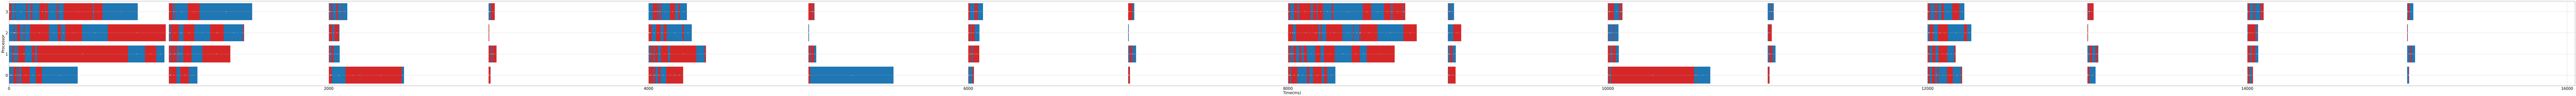

In [473]:
# draw_gantt(pso, MAPPING_ALGORITHM.WORST_FIT_DECREASING, 0.8, 4, [GOAL.RESP_TIME, GOAL.WAIT_TIME])

In [505]:
# draw schedulability graph for utilization
def draw_schedulability_graph(scheduler, mapping, utilizations, num_cores, goal):
    results = []
    for util in utilizations:
        j = read_results_from_file(scheduler, mapping, util, num_cores, goal)
        results.append((util, (np.array(j['lateness'])==0).sum()/len(j['lateness'])))
    print(results)
    # max of plot y is 1, min of plot y is 0
    plt.ylim(0, 1.1)
    plt.plot([r[0] for r in results], [r[1] for r in results])

[(0.7, 0.8), (1, 0.0)]


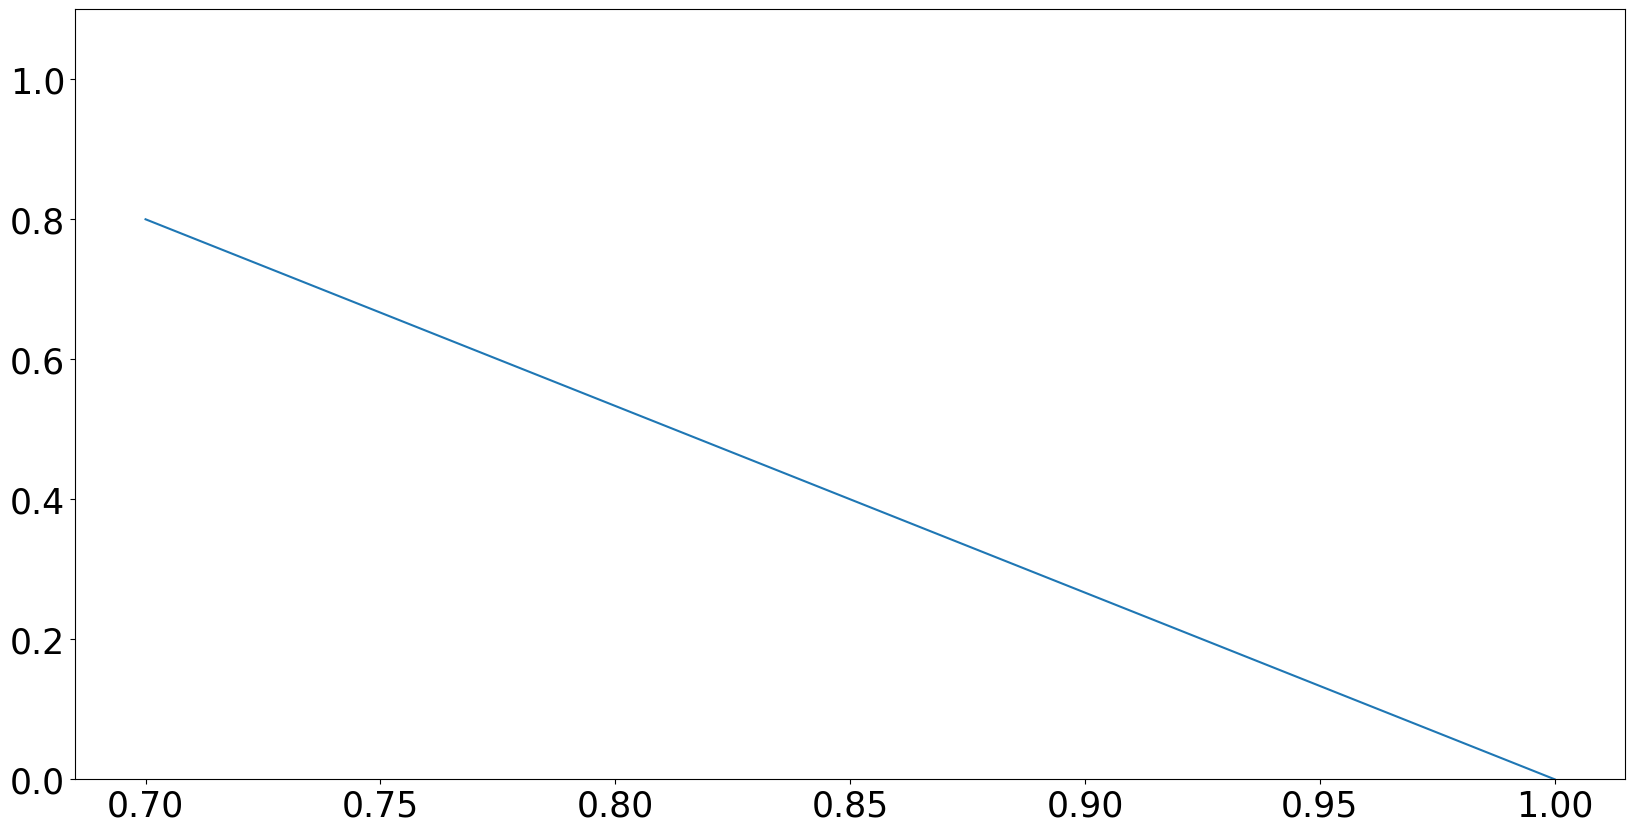

In [524]:
# draw_schedulability_graph(pso, MAPPING_ALGORITHM.WORST_FIT_DECREASING, [.7, 1], 1, [GOAL.RESP_TIME, GOAL.WAIT_TIME])